# MNIST Handwritten Digit Classifier using DNN

In [107]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import sys, os
%matplotlib inline

In [2]:
# Load the Training and Test data
dfTrain = pd.read_csv("..\..\DataSet\mnist_train.csv", encoding="UTF-8")
dfTest = pd.read_csv("..\..\DataSet\mnist_test.csv", encoding="UTF-8")

In [3]:
dfTrain.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
# Train Test Split
Xtrain, Xtest = dfTrain.iloc[:,1:].to_numpy(), dfTest.iloc[:,1:].to_numpy()
Ytrain, Ytest = dfTrain.iloc[:,0].to_numpy(), dfTest.iloc[:,0].to_numpy()

In [32]:
# Range the pixel values 0 to 1
Xtrain = Xtrain / 255.0
Xtest = Ytrain / 255.0

In [26]:
print(Xtrain.shape, Ytrain.shape)

(60000, 784) (60000,)


In [6]:
# Shuffle the data prior training
Xtrain, Ytrain = shuffle(Xtrain, Ytrain, random_state=1)

In [7]:
# show image func
def showImage(x, y):
    z = x.reshape(28,28)
    plt.title("Digit: " + str(y))
    plt.imshow(z)

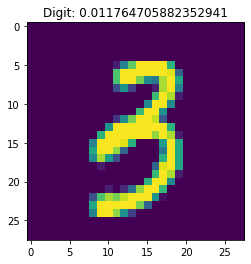

In [28]:
# Sample photo
photo = 0
showImage(Xtrain[photo], Ytrain[photo])

In [9]:
def oneHotEncode(y):
    # Target index matrix from Ytrain
    T = np.zeros((y.shape[0], np.unique(y).shape[0]))

    for i,val in enumerate(y):
        T[i,val] = 1

    return T

In [34]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [11]:
def tanh(z):
    return (np.exp(z)-np.exp(-z)) / (np.exp(z)+np.exp(-z))

In [95]:
def softmax(z):
    return np.exp(z) / np.sum(np.exp(z), axis=1, keepdims=True)

In [13]:
def nonlinearDT(z, func):
    if func == "sigmoid":
        return z*(1-z)
    if func == "tanh":
        return (1-z**2)

In [14]:
def cost(t,y):
    return -np.mean(t*np.log(y))

In [319]:
def forwardProp(X,T,h_layers,lr,activation_func,W,B,A,n,random_state):

    D = X.shape[1] # N.Input nodes
    K = T.shape[1] # N.Output nodes
    L = len(h_layers) # N.Hidden Layers
    np.random.seed(random_state) # Seed

    for i in range(L+1): # including output layer
        if i==0: # At First Layer
            if n==0:
                W[i] = np.random.randn(D,h_layers[i])
                B[i]  = np.random.randn(h_layers[i])
            Z = np.dot(X, W[i]) + B[i]
            A[i] = activation_func(Z)
            
        elif i==L: # At Last Layer
            if n==0:
                W[i] = np.random.randn(h_layers[i-1], K)
                B[i] = np.random.randn(K)
            Z = np.dot(A[i-1], W[i]) + B[i]
            A[i] = softmax(Z) # Multiclass Classification

        else: # At Middle Layers
            if n==0:
                W[i] = np.random.randn(h_layers[i-1], h_layers[i])
                B[i] = np.random.randn(h_layers[i])
            Z = np.dot(A[i-1], W[i]) + B[i]
            A[i] = activation_func(Z)
            
    return W,B,A

In [342]:
def backProp(X,T,h_layers,lr,activation_func,W,B,A):
    
    Y = A[list(A.keys())[-1]] # Predicted Output
    L = len(h_layers) # N.Hidden Layers
    error, delta = {}, {}
    
    for i in range(L,-1,-1):
        if i==L: # At Last Layer
            error[i] = T-Y
            delta[i] = error[i] # softmax layer
            W[i] += lr*np.dot(A[i-1].T, delta[i])
            B[i] += lr*np.sum(delta[i], axis=0)
            #print(B[i])
        elif i==0: # At First Layer
            error[i] = np.dot(delta[i+1], W[i+1].T)
            delta[i] = error[i]*nonlinearDT(A[i], activation_func.__name__)
            W[i] += lr*np.dot(X.T, delta[i])
            B[i] += lr*np.sum(delta[i], axis=0)
            
        else: # At Middle Layers
            error[i] = np.dot(delta[i+1], W[i+1].T)
            delta[i] = error[i]*nonlinearDT(A[i], activation_func.__name__)
            W[i] += lr*np.dot(A[i-1].T, delta[i])
            B[i] += lr*np.sum(delta[i], axis=0)
            
    return W, B, Y

In [397]:
def fit(X, Y, h_layers=[2], lr=0.01, activation_func=sigmoid, iterations=100, random_state=1):
    
    T = oneHotEncode(Y) # Apply One hot encoding
    W, B, A = {}, {}, {} # weights, biases and outputs at each layers
    c = [] # Cost
    
    for n in range(iterations):
        W, B, A = forwardProp(X,T,h_layers,lr,activation_func,W,B,A,n,random_state)
        W, B, Y = backProp(X,T,h_layers,lr,activation_func,W,B,A)
        c.append(cost(T,Y))
    
    Yhat = predict(Y) # Final Prediction for Training Data
    
    return c, Yhat, W, B

In [332]:
def predict(y):
    return np.argmax(y, axis=1)

In [333]:
def accuracy(y, yhat):
    return np.mean(y==yhat)

In [398]:
# Train DNN
C, Yhat, W, B = fit(Xtrain, Ytrain, h_layers=[100], lr=0.00001, activation_func=sigmoid, iterations=100000, random_state=1)

In [399]:
# Accuracy
result = accuracy(Ytrain, Yhat)
print("Training Accuracy: ", result*100)

Training Accuracy:  99.98166666666667


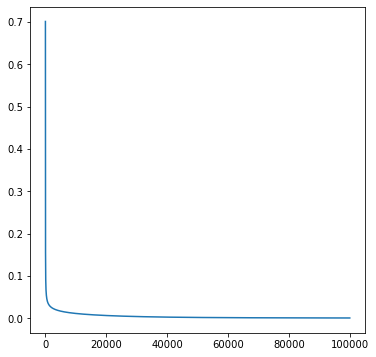

In [400]:
# Cost plot
plt.figure(figsize=(6,6))
plt.plot(C)
plt.show()

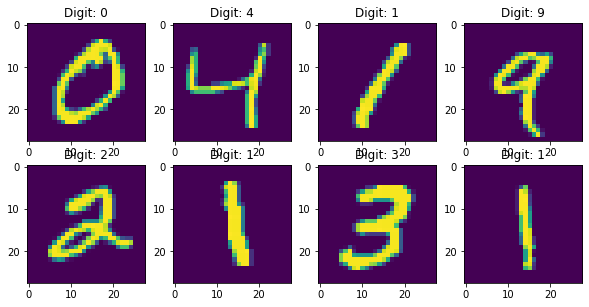

In [401]:
# Predicting Train Images
plt.figure(figsize=(10,10))
for i in range(1,9,1):
    p = str(4)+str(4)+str(i)
    k = int(p)
    plt.subplot(k)
    showImage(Xtrain[i], Yhat[i])